# ELE-32 - LAB 4 - Comparação Justa
---

In [124]:
# Libraries import
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx
from multiprocessing import Pool, set_start_method
import csv
from scipy import special

# 1. Obtenha um gráfico da probabilidade de erro em função de $E_i/N_0$ comparando os seguintes sistemas:
---

## 1.1 Sistema BPSK não codificado (não precisa ser simulado)
---

In [129]:
# Defining a function to calculate the Q value (statistics)
def q(v: np.ndarray) -> np.ndarray:
    return 0.5 - 0.5 * special.erf(v / np.sqrt(2))

# Defining a function to simulate a BPSK uncodified probability error
def pe_bpsk(Eb_N0_dB: np.ndarray) -> np.ndarray:
    Eb_N0 = 10**(Eb_N0_dB / 10)
    return q(np.sqrt(2 * Eb_N0))

In [198]:
# Example of simulation of BPSK uncodified probability error
Eb_N0_range = np.arange(-5, 15.1, 0.01) 
pe_bpsk_values = pe_bpsk(Eb_N0_range)

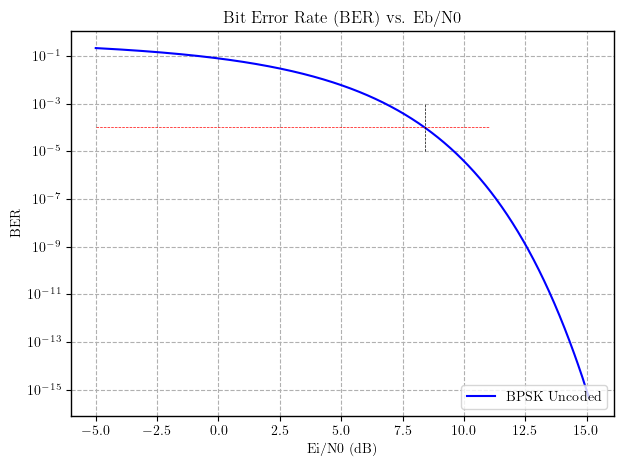

In [231]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
ax.hlines(1e-4, -5, 11, colors="red", linestyles="--", linewidth = 0.5)
ax.vlines(8.4, 1e-5, 1e-3, colors="black", linestyles="--", linewidth = 0.5)
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [132]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(pe_bpsk_values, Eb_N0_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: 8.40000000000001 dB


In [232]:
RSR_BPSK_dB = 8.40
RSR_BPSK_dB

8.4

## 1.2 Código de Hamming do primeiro laboratório
---

In [134]:
# Defining a function as a Hamming coder
def hamming_coder(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity matrix
    G = np.array([[1, 0, 0, 0, 1, 1, 1],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 1, 0, 1, 1]], dtype=int)
    # Encoding the input vector
    output_vector = np.dot(input_vector, G) % 2
    return output_vector

In [135]:
# Define a function for a Binary Symmetric Channel with parameter p
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [136]:
# Define a function for the syndrome calculator
def syndrome(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity-check matrix
    H = np.array([[1, 1, 1, 0, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 1, 0, 1, 0, 0, 1]], dtype=int)
    # Decoding the input vector
    output_vector = np.dot(input_vector, H.T) % 2
    return output_vector

In [137]:
s_dict = {
    '0': (np.array([0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0])),
    '1': (np.array([1, 1, 1]), np.array([1, 0, 0, 0, 0, 0, 0])),
    '2': (np.array([1, 0, 1]), np.array([0, 1, 0, 0, 0, 0, 0])),
    '3': (np.array([1, 1, 0]), np.array([0, 0, 1, 0, 0, 0, 0])),
    '4': (np.array([0, 1, 1]), np.array([0, 0, 0, 1, 0, 0, 0])),
    '5': (np.array([1, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0])),
    '6': (np.array([0, 1, 0]), np.array([0, 0, 0, 0, 0, 1, 0])),
    '7': (np.array([0, 0, 1]), np.array([0, 0, 0, 0, 0, 0, 1]))
}

In [138]:
# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]

In [139]:
# Defining the Hamming decoder function with 1-bit correction
def hamming_decoder(input_vector: np.ndarray) -> np.ndarray:
    s = syndrome(input_vector)
    e_prime = e_prime_calc(s)
    decoded = (input_vector + e_prime) % 2
    return decoded[:4]

In [143]:
def hamming_pb_est(p: float) -> float:
    sample_size = 10_000
    error_count = 0
    k = 4
    l = int(sample_size/k)

    for _ in range(l):
        input_vector = np.random.randint(0, 2, k)
        input_decoded = hamming_coder(input_vector)
        transmitted_vector = bsc(input_decoded, p)
        decoded_vector = hamming_decoder(transmitted_vector)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return (1/sample_size) * error_count 

In [144]:
K = 4
N = 7

R = K/N
R

0.5714285714285714

In [145]:
hamming_pb_est(0.1)

0.067

In [146]:
def hamming_pb_est_parallel(p: float, sample_size: int) -> float:
    error_count = 0
    k = 4

    input_vector = np.random.randint(0, 2, k)
    input_decoded = hamming_coder(input_vector)
    transmitted_vector = bsc(input_decoded, p)
    decoded_vector = hamming_decoder(transmitted_vector)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [171]:
prob_list = np.concatenate((np.arange(0.5, 0.005, -0.01), np.arange(0.004, 0.0001, -0.0005), np.arange(0.0001, 0.00001, -0.00001)))
prob_list.size

67

In [172]:
# 1.5 min
def worker(args):
    prob, sample_size = args
    return hamming_pb_est_parallel(prob, sample_size)

if __name__ == "__main__":
    erros_list_hamming = []
    #prob_list = [0.5, 0.2, 0.1, 0.05, 
    #             0.02, 0.01, 0.005, 0.001, 
    #             0.0005, 0.0004, 0.0003, 0.00025, 
    #             0.0001, 0.00005, 0.00001, 0.000005, 0.00001]    

    prob_list = prob_list

    # Create a Pool of processes
    with Pool() as p:
        for prob in prob_list:
            print(f'calculating {prob}')
            # Map the function to the data
            if prob >= 0.001:
                sample_size = 1_000_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)
            else: 
                sample_size = 2_000_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)

calculating 0.5
calculating 0.49
calculating 0.48
calculating 0.47
calculating 0.45999999999999996
calculating 0.44999999999999996
calculating 0.43999999999999995
calculating 0.42999999999999994
calculating 0.41999999999999993
calculating 0.4099999999999999
calculating 0.3999999999999999
calculating 0.3899999999999999
calculating 0.3799999999999999
calculating 0.3699999999999999
calculating 0.3599999999999999
calculating 0.34999999999999987
calculating 0.33999999999999986
calculating 0.32999999999999985
calculating 0.31999999999999984
calculating 0.30999999999999983
calculating 0.2999999999999998
calculating 0.2899999999999998
calculating 0.2799999999999998
calculating 0.2699999999999998
calculating 0.2599999999999998
calculating 0.24999999999999978
calculating 0.23999999999999977
calculating 0.22999999999999976
calculating 0.21999999999999975
calculating 0.20999999999999974
calculating 0.19999999999999973
calculating 0.18999999999999972
calculating 0.17999999999999972
calculating 0.16

In [173]:
def q_inv(v: np.ndarray) -> np.ndarray:
    return np.sqrt(2) * special.erfinv(np.ones(len(v)) - np.dot(2, v))

def Ei_N0_dB_BSC_convert(prob_list: np.ndarray, R: float) -> np.ndarray:
    Eb_N0 = ((q_inv(prob_list)) ** 2) / 2
    Ei_N0 = Eb_N0 / R
    return 10 * np.log10(Ei_N0)

In [174]:
Ei_N0_from_p_hamming = Ei_N0_dB_BSC_convert(prob_list, R)

/tmp/ipykernel_2444/1399184551.py:7: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(Ei_N0)


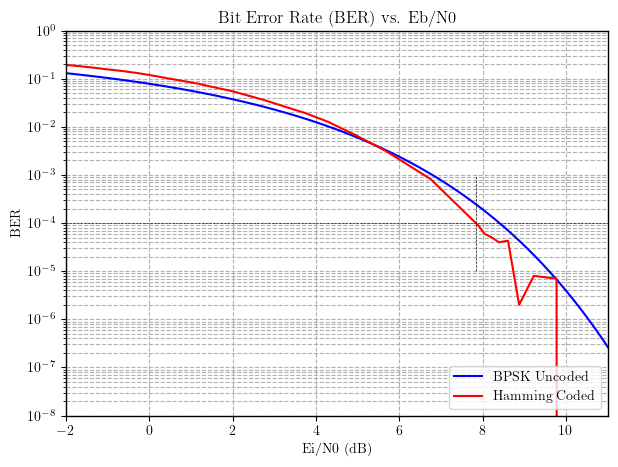

In [240]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded", color='red')
ax.grid(True, which="both", ls="--")
# Set xlims
ax.set_xlim(-2, 11)
ax.set_ylim(1e-8, 1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
ax.hlines(1e-4, -5, 11, colors="blue", linestyles="--", linewidth = 0.5)
ax.vlines(7.84, 1e-5, 1e-3, colors="black", linestyles="--", linewidth = 0.5)
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [176]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(erros_list_hamming, Ei_N0_from_p_hamming)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: 7.89177955826931 dB


In [241]:
RSR_Hamming_dB = 7.84
RSR_Hamming_dB

7.84

## 1.3 Desempenho do código LDPC com $N \approx 1000$ utilizando o algoritmo bit-flipping do segundo laboratório
---

In [178]:
# Define a function to set the parameters
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [179]:
# Define a function for a Binary Symmetric Channel with parameter p
@njit
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [180]:
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [181]:
# Define a function for the parity check matrix
@njit
def parity_check(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check(H, x)
        iteration += 1

    return x

In [182]:
N = 1001
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
LDPC_matrix_PEG = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = 1 - dv/dc
R

0.5714285714285714

In [201]:
@njit
def ham_bit_flip_pb_est(p: float, N: int) -> float:
    sample_size = 5_000_000.
    error_count = 0.
    k = N
    l = int(sample_size/k)
    num_of_bits = l * k

    for _ in range(l):
        input_vector = np.zeros(k, dtype = np.int32)        
        output_vector = bsc(input_vector, p)
        decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count/num_of_bits

In [202]:
a = ham_bit_flip_pb_est(0.02, N)
a

0.002566002566002566

In [203]:
@njit
def ham_bit_flip_pb_est_parallel(p: float, N: int) -> float:
    error_count = 0.
    k = N

    input_vector = np.zeros(k, dtype = np.int32)        
    output_vector = bsc(input_vector, p)
    decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [204]:
prob_list = np.concatenate((np.arange(0.5, 0.005, -0.01), np.arange(0.004, 0.0001, -0.0005), np.arange(0.0001, 0.00001, -0.00001)))
prob_list.size

67

In [205]:
def worker(args):
    prob, N = args
    return ham_bit_flip_pb_est(prob, N)

if __name__ == "__main__":
    erros_list = []
    #prob_list = [0.5, 0.2, 0.1, 0.05, 
    #             0.02, 0.01, 0.005, 0.001, 
    #             0.0005, 0.0004, 0.0003, 0.00025, 
    #             0.0001, 0.00005, 0.00001, 0.000005, 0.00001]
    prob_list = prob_list
    #sample_size = 100_000
    #l = int(sample_size/4)
    #num_of_bits = l * N

    # Create a Pool of processes
    with Pool() as p:
        #for prob in prob_list:
            # Map the function to the data
            erros_list_bit_flip = np.array(p.map(worker, [(prob, N) for prob in prob_list]))
            #erros_list.append(np.sum(erros)/num_of_bits)

In [208]:
a, erros

(0.002566002566002566, array([], dtype=float64))

In [209]:
Ei_N0_from_p_bit_flip = Ei_N0_dB_BSC_convert(prob_list, R)

/tmp/ipykernel_2444/1399184551.py:7: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(Ei_N0)


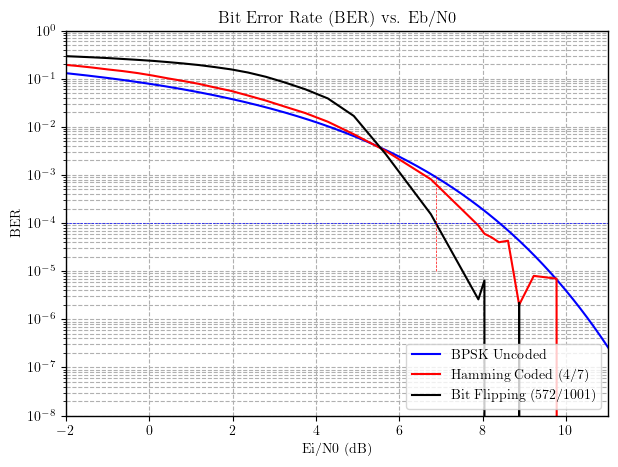

In [311]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (572/1001)", color='black')
ax.grid(True, which="both", ls="--")
# Set xlims
ax.set_xlim(-2, 11)
ax.set_ylim(1e-8, 1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
ax.hlines(1e-4, -5, 11, colors="blue", linestyles="--", linewidth = 0.5)
ax.vlines(6.87, 1e-5, 1e-3, colors="red", linestyles="--", linewidth = 0.5)
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [212]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(erros_list_bit_flip, Ei_N0_from_p_bit_flip)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: 7.89177955826931 dB


In [249]:
RSR_bit_flip_dB = 6.87
RSR_bit_flip_dB

6.87

## 1.4 Desempenho do código LDPC com N $\approx$ 1000 utilizando o algoritmo que usa LLRs do terceiro laboratório
---

In [250]:
@njit
def calcular_variancia_ruido(Eb_N0_dB: float) -> float:
    """
    Calcula a variância do ruído com base na relação sinal-ruído Eb/N0 em decibéis.

    Args:
        Eb_N0_dB (float): A relação sinal-ruído Eb/N0 em decibéis.

    Returns:
        float: A variância do ruído.

    """
    # Converter a relação sinal-ruído Eb/N0 de decibéis para linear
    Eb_N0 = 10**(Eb_N0_dB / 10)

    # Calcular a densidade espectral de potência do ruído
    N0 = 1 / Eb_N0

    # Calcular a variância do ruído
    sigma2 = N0 / 2

    return sigma2

@njit 
def gerar_simbolos_bpsk_zero(num_bits: int) -> np.ndarray:
    """
    Gera símbolos BPSK com todos os bits iguais a zero.

    Parâmetros:
    - num_bits: O número de bits a serem gerados.

    Retorna:
    - Uma sequência de símbolos BPSK com todos os bits iguais a zero.
    """
    return np.full(num_bits, 1)

@njit
def calcular_valor_recebido(simbolos: np.ndarray, Eb_N0_dB: float) -> np.ndarray:
    """
    Calcula o valor recebido adicionando ruído gaussiano aos símbolos transmitidos.

    Parâmetros:
    simbolos (array): Array contendo os símbolos transmitidos.
    Eb_N0_dB (float): Relação sinal-ruído em dB.

    Retorna:
    array: Array contendo os símbolos recebidos após a adição de ruído gaussiano.
    """
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

@njit
def calcular_valores_llr(r: np.ndarray, sigma2: float) -> np.ndarray:
    """
    Calcula os valores do Log-Likelihood Ratio (LLR) para uma sequência de bits recebida.

    Args:
        r (float): A sequência de bits recebida.
        sigma2 (float): A variância do ruído.

    Returns:
        float: Os valores do LLR para cada bit da sequência recebida.
    """
    llr = 2 * r / sigma2
    return llr

# Define a function for the parity check matrix
@njit
def syndrome_calc(H: np.array, x: np.array) -> np.array:
    """
    Calcula o vetor de síndrome de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - x: O vetor de bits a ser verificado.

    Retorna:
    - Um vetor de síndrome.
    """
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * x) % 2
    
    return s

@njit
def parity_check(H: np.array, y: np.array) -> bool:
    """
    Verifica se um vetor y é um código válido de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - y: O vetor de bits a ser verificado.

    Retorna:
    - Um valor booleano indicando se o vetor y é um código válido.
    """
    x = y.copy()
    for i in range(len(y)):
        if x[i] > 0:
            x[i] = 0
        else:
            x[i] = 1

    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = syndrome_calc(H, x)
    
    for i in range(column_length):
        errors[i] = np.sum(H[:, i] * s)

    if np.sum(errors) == 0:
        return True
    else:
        return False

@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    """
    Define os parâmetros do código LDPC.

    Args:
        N (int): O tamanho do código.
        dv (int): O grau do vetor de checagem.
        dc (int): O grau do vetor de informação.

    Returns:
        tuple[int, int]: Uma tupla contendo o tamanho da mensagem (K) e o tamanho do código (M).
    
    Raises:
        ValueError: Se N não for divisível por dc.
    """
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)
    
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)
    
@njit
def inicializar_mensagens(H: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Inicializa as mensagens dos c-nodes para os v-nodes e dos v-nodes para os c-nodes.

    Args:
        H (numpy.ndarray): Matriz de verificação de paridade (H).

    Returns:
        tuple: Uma tupla contendo as mensagens dos c-nodes para os v-nodes (Le) e as mensagens dos v-nodes para os c-nodes (Lr).
    """
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

@njit
def atualizar_mensagens_vnodes(Lr: np.ndarray, Lc: np.ndarray, Le: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós variáveis (v-nodes) de acordo com a matriz de paridade H.

    Parâmetros:
    - Lr: numpy.ndarray, matriz de mensagens nos nós de verificação (r-nodes)
    - Lc: numpy.ndarray, vetor de mensagens nos nós de checagem (c-nodes)
    - Le: numpy.ndarray, matriz de mensagens extrínsecas
    - H: numpy.ndarray, matriz de paridade

    Retorna:
    - Lr: numpy.ndarray, matriz de mensagens atualizadas nos nós de verificação (r-nodes)
    """
    num_cnodes, num_vnodes = H.shape
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr

@njit
def atualizar_mensagens_cnodes(Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós de verificação (cnodes) de acordo com a matriz de paridade H.

    Args:
        Le (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos cnodes.
        Lr (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos vnodes.
        H (numpy.ndarray): Matriz de paridade que define as conexões entre cnodes e vnodes.

    Returns:
        numpy.ndarray: Array bidimensional com as mensagens atualizadas nos cnodes.
    """
    num_cnodes, num_vnodes = H.shape
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                # Calcula o produto dos sinais
                product_sign = 1
                min_value = np.inf
                for k in range(num_vnodes):
                    if k != i and H[j, k] == 1:
                        product_sign *= np.sign(Lr[j, k])
                        min_value = min(min_value, abs(Lr[j, k]))
                # Calcula a mensagem de saída usando a equação 11
                Le[j, i] = product_sign * min_value
    return Le

@njit
def iteracao(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Realiza uma iteração do algoritmo de decodificação LDPC.

    Parâmetros:
    Lc (array): Array contendo as mensagens a priori dos c-nodes.
    Le (array): Array contendo as mensagens a priori dos v-nodes.
    Lr (array): Array contendo as mensagens dos v-nodes para os c-nodes.
    H (array): Matriz de verificação de paridade.

    Retorna:
    decision (array): Array contendo as decisões de bits após a iteração.
    """
    # Atualizar mensagens dos v-nodes
    Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
    
    # Atualizar mensagens dos c-nodes
    Le = atualizar_mensagens_cnodes(Le, Lr, H)
    
    # Critério de parada: verificar se todas as equações de paridade são satisfeitas
    decision = np.sign(Lc + np.sum(Le, axis=0))
    return decision


@njit
def dot_product(H: np.ndarray, decision: np.ndarray) -> np.ndarray:
    """
    Calcula o produto escalar entre a matriz de verificação de paridade e as decisões de bits.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - decision: As decisões de bits.

    Retorna:
    - Um vetor de bits resultante do produto escalar.
    """
    result = np.zeros(H.shape[0], dtype=H.dtype)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            result[i] += H[i, j] * decision[j]
    return result

@njit
def ldpc_decode(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray, max_iter: int = 50) -> np.ndarray:
    """
    Decodifica uma sequência de bits usando o algoritmo LDPC.

    Parâmetros:
    - Lc: array numpy de tamanho N, contendo as log-verossimilhanças dos bits recebidos.
    - H: array numpy de tamanho MxN, contendo a matriz de verificação de paridade LDPC.
    - max_iter: número máximo de iterações do algoritmo (padrão: 100).

    Retorna:
    - decoded_bits: array numpy de tamanho N, contendo os bits decodificados.

    """

    Le, Lr = inicializar_mensagens(H)
    n = 0

    for _ in range(max_iter):
        n += 1
        decision = iteracao(Lc, Le, Lr, H)
        if parity_check(H, decision):
            break
    
    # print(f"{n} iterações")
    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf).astype(np.int32)
    return decoded_bits

In [265]:
# Definindo os parâmetros para simulação
num_bits = 1001
Eb_N0_dB_range = np.arange(-2.5, 15.5, 0.2)

N = num_bits
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = 1 - dv/dc
is_peg_matrix(H)

True

In [266]:
Eb_N0_dB_range.size

90

In [267]:
@njit
def simular_desempenho_ldpc_parallel_iter(H: np.ndarray, num_bits: int, Eb_N0_dB: float) -> float:
    # Gerar símbolos BPSK
    simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
    
    # Calcular valores recebidos com ruído
    r = calcular_valor_recebido(simbolos, Eb_N0_dB)
    
    # Calcular valores LLR
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    Lc = calcular_valores_llr(r, sigma2)
    
    # Decodificar
    Le, Lr = inicializar_mensagens(H)
    bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter = 10).astype(np.float64)
        
    return np.count_nonzero(simbolos != bits_decodificados)

@njit
def ber_total(erros: np.ndarray, num_iter: int, num_bits: int) -> float:
    return np.sum(erros) / (num_iter * num_bits)

In [268]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.arange(-2.5, 11, 0.5)  # replace with your actual range
    num_iter =  np.full(shape = len(Eb_N0_dB), fill_value = 5_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list.append(ber)

In [269]:
Ei_N0_from_p_ldpc = Eb_N0_dB / R

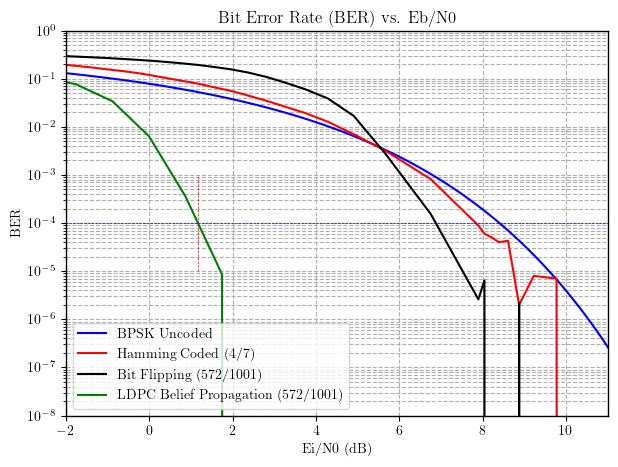

In [310]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (572/1001)", color='black')
ax.plot(Ei_N0_from_p_ldpc, ber_list, label=r"LDPC Belief Propagation (572/1001)", color='green')
ax.grid(True, which="both", ls="--")
# Set xlims
ax.set_xlim(-2, 11)
ax.set_ylim(1e-8, 1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
ax.hlines(1e-4, -5, 11, colors="blue", linestyles="--", linewidth = 0.5)
ax.vlines(1.163, 1e-5, 1e-3, colors="red", linestyles="--", linewidth = 0.5)
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [271]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_list, Ei_N0_from_p_ldpc)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: 1.75 dB


In [286]:
RSR_LDPC_dB = 1.163
RSR_LDPC_dB

1.163

## 1.5 Desempenho do código LDPC com N $\approx$ 1000 utilizando o algoritmo próprio
---

In [287]:
# Definindo os parâmetros para simulação
num_bits = 1002
Eb_N0_dB_range = np.arange(-2, 15.5, 0.5)

N = num_bits
dv = 3
dc = 6
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = 1 - dv/dc
is_peg_matrix(H), R

(True, 0.5)

In [288]:
if __name__ == "__main__":
    ber_list_custom = []
    Eb_N0_dB = np.arange(-2.5, 11, 0.5)  # replace with your actual range
    num_iter =  np.full(shape = len(Eb_N0_dB), fill_value = 5_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list_custom.append(ber)

In [289]:
Ei_N0_from_p_ldpc_custom = Eb_N0_dB/R

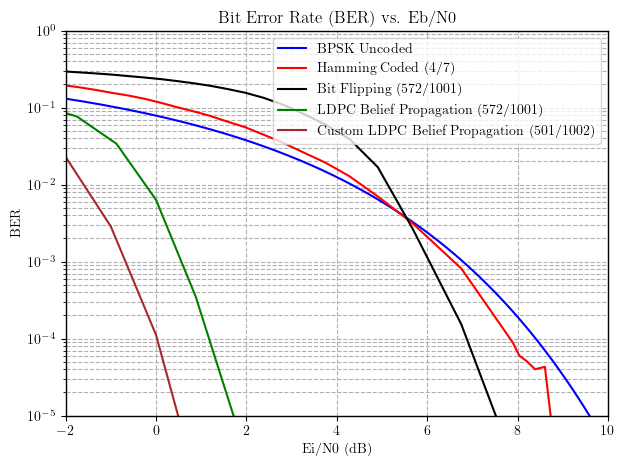

In [309]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (572/1001)", color='black')
ax.plot(Ei_N0_from_p_ldpc, ber_list, label=r"LDPC Belief Propagation (572/1001)", color='green')
ax.plot(Ei_N0_from_p_ldpc_custom, ber_list_custom, label=r"Custom LDPC Belief Propagation (501/1002)", color='brown')
ax.grid(True, which="both", ls="--")
# Set xlims
ax.set_xlim(-2, 10)
ax.set_ylim(1e-5, 1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 1)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#ax.hlines(1e-4, -5, 11, colors="blue", linestyles="--", linewidth = 0.5)
#ax.vlines(0.02, 1e-5, 1e-3, colors="black", linestyles="--", linewidth = 0.5)
#plt.gca().invert_xaxis()
plt.savefig('error_rate_comparison.pdf')
plt.show()

In [291]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_list_custom, Ei_N0_from_p_ldpc_custom)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: 1.0 dB


In [302]:
RSR_LDPC_custom_dB = 0.02
RSR_LDPC_custom_dB

0.02

# 2. Compare a RSR necessária para se atingir probabilidade de erro de bit menor do que $10^{-4}$
---

## 2.1 Obtenha a RSR em que cada um dos 5 sistemas acima tem o desempenho desejado. Esta é a RSR operacional
---

Para a relação $E_i/N_0$, as seguintes RSR são obtidas:

In [303]:
RSR_BPSK_dB, RSR_Hamming_dB, RSR_bit_flip_dB, RSR_LDPC_dB, RSR_LDPC_custom_dB

(8.4, 7.84, 6.87, 1.163, 0.02)

## 2.2 Obtenha a taxa (em bits de informação por uso de canal) com a qual cada um dos sistemas opera
---

In [312]:
R_BPSK = 1
R_Hamming = 4/7
R_bit_flip = 572/1001
R_LDPC = 572/1001
R_LDPC_custom = 501/1002

R_BPSK, R_Hamming, R_bit_flip, R_LDPC, R_LDPC_custom

(1, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5)

## 2.3 Obtenha o valor da RSR mínima exigida para que a capacidade do canal Gaussiano seja igual à taxa do item anterior
---

In [314]:
def RSR_ideal_dB(R):
    RSR = 2**(2*R) - 1
    return 10 * np.log10(RSR)

In [324]:
RSR_BPSK_ideal = RSR_ideal_dB(R_BPSK)
RSR_Hamming_ideal = RSR_ideal_dB(R_Hamming)
RSR_bit_flip_ideal = RSR_ideal_dB(R_bit_flip)
RSR_LDPC_ideal = RSR_ideal_dB(R_Hamming)
RSR_LDPC_custom_ideal = RSR_ideal_dB(R_LDPC_custom)

RSR_BPSK_ideal, RSR_Hamming_ideal, RSR_bit_flip_ideal, RSR_LDPC_ideal, RSR_LDPC_custom_ideal

(4.771212547196624,
 0.8213129258674992,
 0.8213129258674992,
 0.8213129258674992,
 0.0)

## 2.4 Calcule a diferença entre a RSR exigida e a operacional de cada um dos sistemas
---

In [328]:
(RSR_BPSK_ideal - RSR_BPSK_dB,
RSR_Hamming_ideal - RSR_Hamming_dB, 
RSR_bit_flip_ideal - RSR_bit_flip_dB, 
RSR_LDPC_ideal - RSR_LDPC_dB, 
RSR_LDPC_custom_ideal - RSR_LDPC_custom_dB)

(-3.628787452803376,
 -7.018687074132501,
 -6.048687074132501,
 -0.3416870741325009,
 -0.02)